In [21]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import json
from itertools import permutations
import random
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [42]:
data_folder = Path("/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

## Audio signals

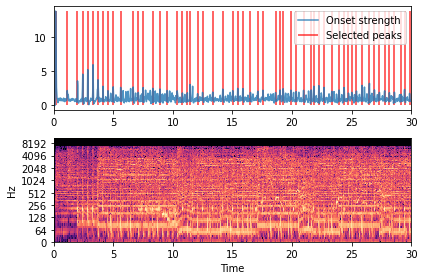

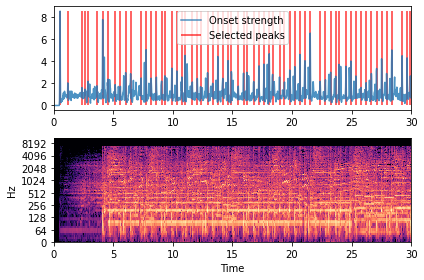

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)

## Minhash

Create a dictionary with the shingles

In [45]:
def createShingles(tracks):
    
    shingles={} #ogni track in che indici ha i peaks
    for idx, audio in enumerate(tracks):
        track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
        shingles[idx] = peaks.tolist()

In [38]:
shingles = createShingles(tracks)

1410

Save the shingles dict into a json file

In [9]:
shingles_file = open("shingles.json", "w")
json.dump(shingles, shingles_file)
shingles_file.close()

Load the shingles file

In [26]:
shingles_file = open("shingles.json", "r")
shingles = json.load(shingles_file)

Create the signature matrix

In [35]:
def minHash(shingles):
    
    # Create signature Data Frame with 10 permutations
    signature = pd.DataFrame(columns=["track_{i}".format(i=i) for i in range(1413)],
                             index=[i for i in range(20)])

    for i in range(20):
        rows = [i for i in range(1292)]
        random.shuffle(rows)
        
        # Create Data Frame with all 0s where columns are tracks and rows are peaks
        df = pd.DataFrame(data=np.zeros((1292,1413)), 
                      columns=["track_{i}".format(i=i) for i in range(1413)],
                      index=[rows])
        
        # Insert 1 in the Data Frame if the peak is inside the track
        for track, peaks in shingles.items():
            df.loc[peaks, "track_{i}".format(i=track)] = 1
        
        for track in df.columns:
            for j, row in enumerate(list(df[track])):
                if row == 1:
                    signature.loc[i, track] = j
                    break
    
    return signature

In [36]:
minHashSignature = minHash(shingles)

In [37]:
minHashSignature

,track_0,track_1,track_2,track_3,track_4,track_5,track_6,track_7,track_8,track_9,...,track_1403,track_1404,track_1405,track_1406,track_1407,track_1408,track_1409,track_1410,track_1411,track_1412
0,26,0,7,2,4,31,15,27,41,70,...,0,15,2,21,7,14,19,NaN,NaN,NaN
1,3,40,38,20,10,9,88,4,10,6,...,28,5,2,60,21,4,95,NaN,NaN,NaN
2,8,25,16,20,20,25,20,15,12,13,...,30,19,3,45,1,8,13,NaN,NaN,NaN
3,13,4,20,4,0,22,2,6,12,11,...,33,7,25,72,12,6,1,NaN,NaN,NaN
4,18,13,11,36,18,9,59,0,33,24,...,24,37,21,61,27,0,54,NaN,NaN,NaN
5,13,24,4,5,6,33,62,44,11,87,...,6,73,15,21,4,39,36,NaN,NaN,NaN
6,14,11,17,1,0,0,12,13,30,65,...,10,46,11,17,1,4,22,NaN,NaN,NaN
7,35,20,14,20,26,9,44,18,14,9,...,6,45,2,0,52,2,68,NaN,NaN,NaN
8,1,9,1,21,21,9,9,0,68,9,...,0,77,11,25,6,27,71,NaN,NaN,NaN
9,2,1,17,1,10,48,12,17,10,6,...,33,4,10,25,47,4,9,NaN,NaN,NaN


Define the Locality Sensitive Hashing function to create the buckets

In [ ]:
def LSH(minHashSignature):
    
    buckets = []
    threshold = 0.8
    b = 2
    n_bands = len(minHashSignature.index) // b

    for i in range(0, len(minHashSignature.index), b):
        band = minHashSignature[i:i+b]

        peaks_lst = []
        for track, peaks in band.items():
            peaks_lst.append(list(peaks))

        # Calculate Jaccard similarity for couples of tracks
        for i in range(len(peaks_lst)-1):
            intersection = len(list(set(peaks_lst[i]).intersection(peaks_lst[i+1])))
            union = (len(peaks_lst[i]) + len(peaks_lst[i+1])) - intersection
            jaccardSim = float(intersection) / union

            if jaccardSim >= threshold:
                # mettile nello stesso bucket
                
    return buckets

## Query

In [40]:
data_folder = Path("/home/roberta/dataScience/01/algorithmicMethodsDataMining/hw4/query/")
query = data_folder.glob("*/*/*.wav")

### Query processing

In [ ]:
queryShingles = createShingles(tracks)

In [ ]:
minHashQuerySignature = minHash(queryShingles)